In [32]:
import urllib
import zipfile
import os
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt

In [33]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
data_dir = Path('../data/')
data_dir.mkdir(exist_ok=True, parents=True)
if not data_dir.exists():
  urllib.request.urlretrieve('https://docs.google.com/uc?export=download&id=1-ZqL_1cqWeG6LsRAB0TwiddW8TgQ-q70', data_dir/'Denoising_Data.zip')
  with zipfile.ZipFile(data_dir / 'Denoising_Data.zip', 'r') as zip_ref:
     zip_ref.extractall(data_dir)

In [34]:
# load training data, used to update CNN weights
# 2000 30x30 image patches from 8 patients
train_input = np.load(data_dir/'Denoising_Data/train_input.npy')
train_target = np.load(data_dir/'Denoising_Data/train_target.npy')
# load validation data, used to monitor for overfitting
# 1000 30x30 image patches from 1 patient
val_input = np.load(data_dir/'Denoising_Data/val_input.npy')
val_target = np.load(data_dir/'Denoising_Data/val_target.npy')

# load testing data, used for evaluating performance
# 5 512x512 images from 1 patient
test_input = np.load(data_dir/'Denoising_Data/test_input.npy')
test_target = np.load(data_dir/'Denoising_Data/test_target.npy')

# Load examples images from state-of-the-art CNN denoising for CT images
test_example = np.load(data_dir/'Denoising_Data/test_input_denoised.npy')

print('Data loading completed.')

Data loading completed.


In [35]:
# This is a helper function that plots images using typical CT windows
def ctshow(img, window='soft_tissue'):
  # Define some specific window settings here
  if window == 'soft_tissue':
    ww = 400
    wl = 40
  elif window == 'bone':
    ww = 2500
    wl = 480
  elif window == 'lung':
    ww = 1500
    wl = -600
  else:
    ww = 6.0 * img.std()
    wl = img.mean()

  # Plot image on clean axes with specified window level
  vmin = wl - ww // 2
  vmax = wl + ww // 2
  plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])

  return

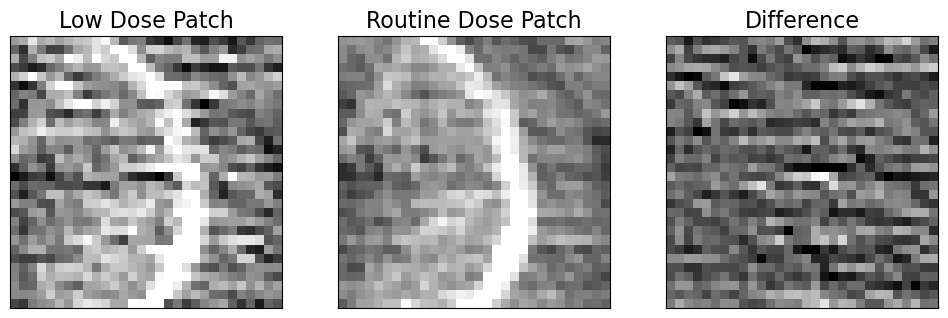

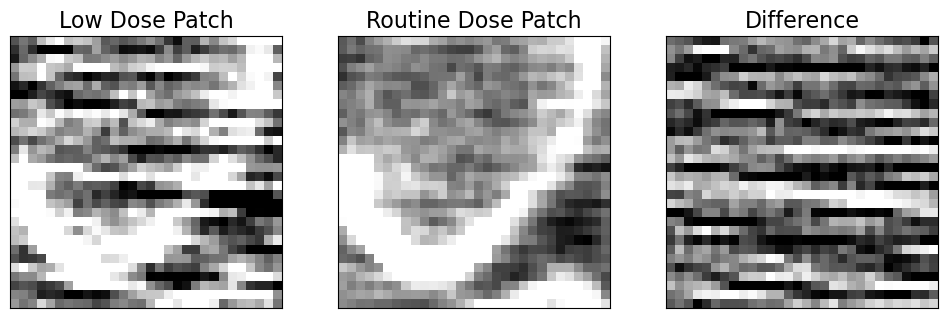

In [36]:
image_examples = [3, 16, 36]
window = 'soft_tissue'

for row in range(2):

  plt.figure(figsize=(12, 12))
  nexample = image_examples[row]

  # Simulated low-dose example
  plt.subplot(3, 3, 1+row*3)
  plt.title('Low Dose Patch', fontsize=16)
  ctshow(train_input[nexample, :, :, 0], window=window)

  # Simulated routine-dose example
  plt.subplot(3, 3, 2+row*3)
  plt.title('Routine Dose Patch', fontsize=16)
  ctshow(train_target[nexample, :, :, 0], window=window)
  plt.subplot(3, 3, 3+row*3)

  # Difference between low-dose and routine-dose to visualize CT noise
  plt.title('Difference', fontsize=16)
  ctshow(train_target[nexample, :, :, 0] - train_input[nexample, :, :, 0],
           window=window)

In [37]:
n_layers = 6
filters = 64
kernel_size = (3, 3)
strides = (1, 1)
activation = 'relu'

def build_model():
    xin = keras.layers.Input(shape=(None, None, 1), name='input_CT_images')
    # We define a preprocessing layer to rescale the CT image pixel values
    shift_mean = train_input.mean()
    rescale = train_input.std()
    x = keras.layers.Lambda(
        lambda x: (x - shift_mean) / rescale,
        name='normalization')(xin)

    for i in range(n_layers - 1):
        x = keras.layers.Conv2D(
          filters=filters,
          kernel_size=kernel_size,
          strides=strides,
          padding='same')(x)
        x = keras.layers.Activation(activation)(x)
    # Final layer has just one feature map corresponding to the output image
    x = keras.layers.Conv2D(
        filters=1,
        kernel_size=kernel_size,
        strides=strides,
        padding='same')(x)
    # Here we rescale the output to typical CT number range
    xout = keras.layers.Lambda(
        lambda x: (x * rescale) + shift_mean,
        name='output_CT_images')(x)
    # We define the model by specifying the inputand output tensors
    model = keras.Model(inputs=xin, outputs=xout, name="CT_denoiser")
    return model

In [38]:
noise_patch_dir = Path('../noise_patches')
# diameters = [112, 131, 151, 185, 200, 216, 292, 350]
# diameters = [151]
diameters = [112, 131]

noise_files = [noise_patch_dir / f'diameter{d}mm.npy' for d in diameters]
noise_patch_dict = {f.stem: np.load(f) for f in noise_files}
noise_patches = np.concatenate(list(noise_patch_dict.values()))
# noise_patches = np.zeros_like(noise_patches)

In [39]:
def load_noise_patches(diameters=[112, 131, 151, 185, 200, 216, 292, 350]):
    noise_files = [noise_patch_dir / f'diameter{d}mm.npy' for d in diameters]
    noise_patch_dict = {f.stem: np.load(f) for f in noise_files}
    return np.concatenate(list(noise_patch_dict.values()))

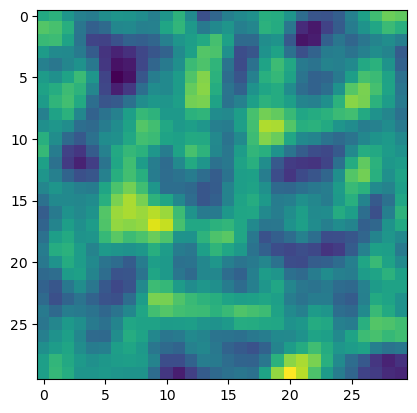

In [40]:
patches = load_noise_patches([112])
plt.imshow(noise_patches[0])

In [41]:
from nps_utils import compute_nps

Look at the average NPS of all the patches

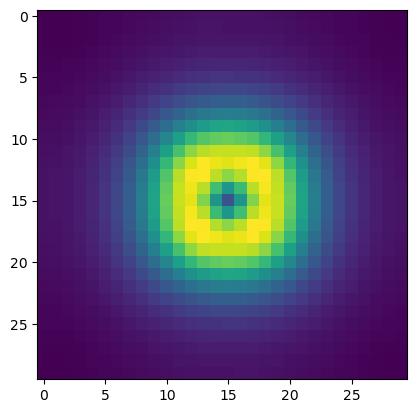

In [42]:
patches = load_noise_patches()
nps = compute_nps(patches)
plt.imshow(nps)

In [43]:
len(patches)

480000

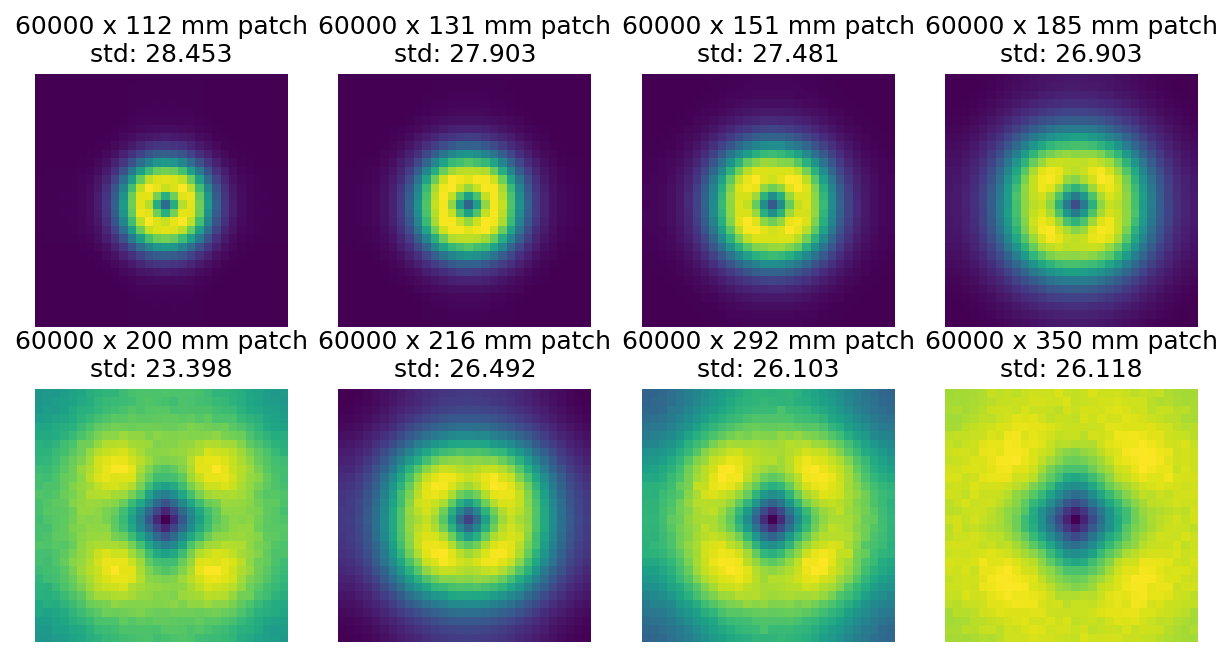

In [44]:
diameters = [112, 131, 151, 185, 200, 216, 292, 350]
f, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 5), dpi=150)
for d, ax in zip(diameters, axs.flatten()):
    patches = load_noise_patches([d])
    nps = compute_nps(patches)
    ax.imshow(nps)
    ax.axis('off')
    ax.set_title(f'{len(patches)} x {d} mm patch\nstd: {patches.std():3.3f}')

## How does the noise level and NPS compare to the training, validation, and testing sets?

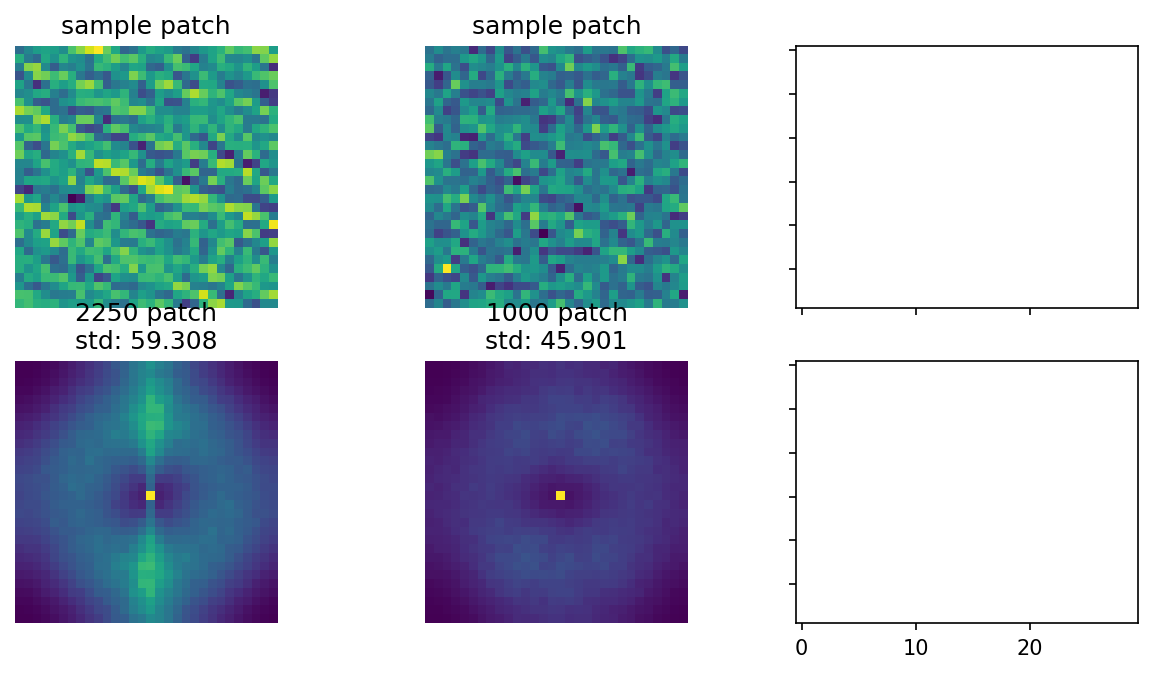

In [45]:
dset = [(train_input, train_target), (val_input, val_target)]
f, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 5), dpi=150)
for idx, d in enumerate(dset):
    patches = d[1] - d[0]
    nps = compute_nps(patches)
    axs[0, idx].imshow(patches[0])
    axs[0, idx].set_title('sample patch')
    axs[0, idx].axis('off')
    axs[1, idx].imshow(nps)
    axs[1, idx].axis('off')
    axs[1, idx].set_title(f'{len(patches)} patch\nstd: {patches.std():3.3f}')

In [46]:
noise_patches = load_noise_patches([112, 131, 151, 185, 216, 292])

In [47]:
noise_patches.std()

27.234627781325866

In [48]:
def get_dataset_std(input, target=None):
    if target is not None:
        return np.std(input - target)
    else:
        return np.std(input)

In [49]:
get_dataset_std(2*noise_patches)

54.46925556265173

In [50]:
get_dataset_std(train_input, train_target), get_dataset_std(val_input, val_target), get_dataset_std(test_input, test_target)

(59.30752, 45.900925, 32.779)

In [51]:
def augment(image_label, seed, max_noise=1):
  image, label = image_label
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  noise_patch = noise_patches[np.random.choice(list(range(len(noise_patches))))][:,:,None]
  noise_lambda = tf.random.uniform([1], minval=0, maxval=max_noise)[0]
  add_noise = tf.random.uniform([1], minval=0, maxval=1) > 0.6 #from 0.5

  # print(f'lambda: {noise_lambda:0.2f}, add_noise: {add_noise}')
  if add_noise:
    image = label + noise_lambda*noise_patch
  return image, label

Simpler augmentation block below

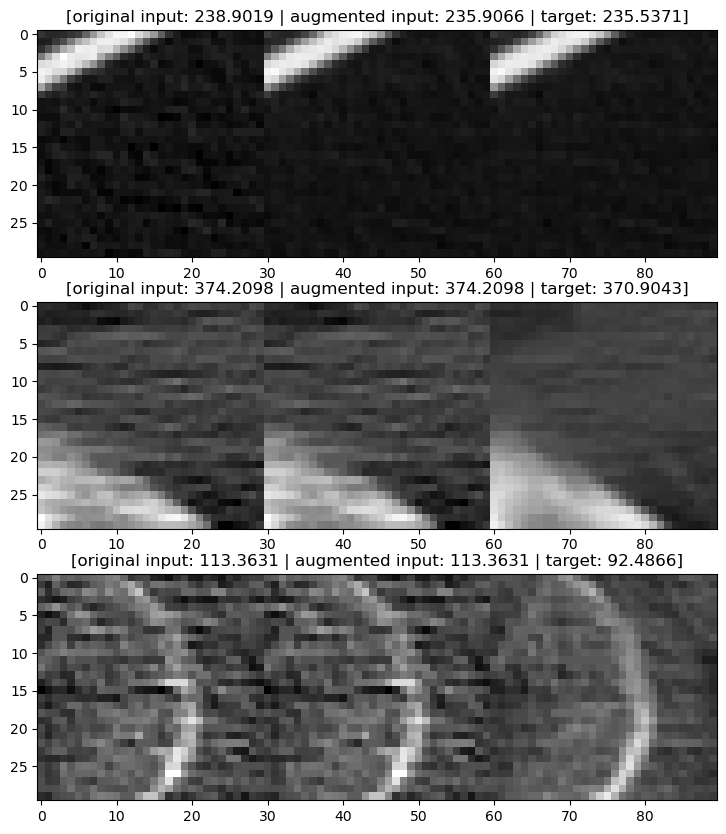

In [52]:
batch_size = 32
SHUFFLE_BUFFER_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

rng = tf.random.Generator.from_seed(123, alg='philox')
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(3):
    img = np.squeeze(images[i])
    aug_image = np.squeeze(f(images[i], labels[i])[0])
    lbl = np.squeeze(labels[i])
    diff = aug_image - img

    axs[i].imshow(np.concatenate([img, aug_image, lbl], axis=1), cmap='gray')
    axs[i].set_title(f'[original input: {img.std():0.4f} | augmented input: {aug_image.std():0.4f} | target: {lbl.std():0.4f}]')

I like it when it clearly adds a chunky noise on top, that lowe  frequency is what I want to train it ro remove

In [53]:
example_input = test_input[[3], ...]
edge_buffer = 128
progress_ims = []
progress_val = []

class CustomCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
            val_loss = self.model.evaluate(val_input, val_target)
            example_output = self.model.predict(example_input)
            example_img = example_output[0, edge_buffer:-edge_buffer,
                                         edge_buffer:-edge_buffer, 0]
            progress_ims.append(example_img)
            progress_val.append(val_loss)

    def on_epoch_end(self, epoch, logs=None):
        model = self.model.predict


In [54]:
from tensorflow.keras.metrics import RootMeanSquaredError

batch_size = 32
SHUFFLE_BUFFER_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

rng = tf.random.Generator.from_seed(123, alg='philox')
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# This sets the number of iterations through the training data
epochs = 15
batch_size = 32
learning_rate = 0.0001
optimizer = tf.keras.optimizers.legacy.Adam(lr=learning_rate)

progress_example = 2
buffer = 128

AUTOTUNE = tf.data.AUTOTUNE

def train(augment_training=False):

    train_ds = (
        train_dataset
        .map(f, num_parallel_calls=AUTOTUNE)
        .prefetch(AUTOTUNE)
    ) if augment_training else (
        train_dataset
       .prefetch(AUTOTUNE)
    )
    model = build_model()
    model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])

    # As the training progresses, we'll monitor network output and performance
    # metrics. Some related variables are initialized here
    example_input = test_input[[3], ...]
    edge_buffer = 128
    progress_ims = []
    progress_val = []

    for epoch in range(epochs):
      # Evaluate model on reserved data
      val_loss = model.evaluate(val_input, val_target)
      example_output = model.predict(example_input)
      example_img = example_output[0, edge_buffer:-edge_buffer,
                                edge_buffer:-edge_buffer, 0]
      progress_ims.append(example_img)
      progress_val.append(val_loss)
      # Update model weights using training data
      istart = 0
      while istart < (len(train_input) - batch_size):
        for x, y in train_ds.take(1):
            model.train_on_batch(x=x, y=y)
        istart += batch_size

    progress_ims = np.stack(progress_ims, axis=0)

    print('Training phase complete.')
    return model, progress_ims, progress_val

In [55]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

base_denoising_model, base_progress_ims, base_progress_val = train(augment_training=False)

1/1 [==============================] - 0s 9ms/step
Training phase complete.


In [63]:
base_denoising_model.

In [56]:
def check_progress_ims(progress_ims):
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 2, 1)
    plt.title('Before Optimization', fontsize=16)
    ctshow(progress_ims[0, :, :], window='variable')

    plt.subplot(2, 2, 2)
    plt.title('Epoch %d/%d' %(1, epochs), fontsize=16)
    ctshow(progress_ims[1, :, :], window='soft_tissue')

    plt.subplot(2, 2, 3)
    plt.title('Epoch %d/%d' %(5, epochs), fontsize=16)
    ctshow(progress_ims[5, :, :], window='soft_tissue')

    plt.subplot(2, 2, 4)
    plt.title('Final Epoch', fontsize=16)
    ctshow(progress_ims[-1, :, :], window='soft_tissue')

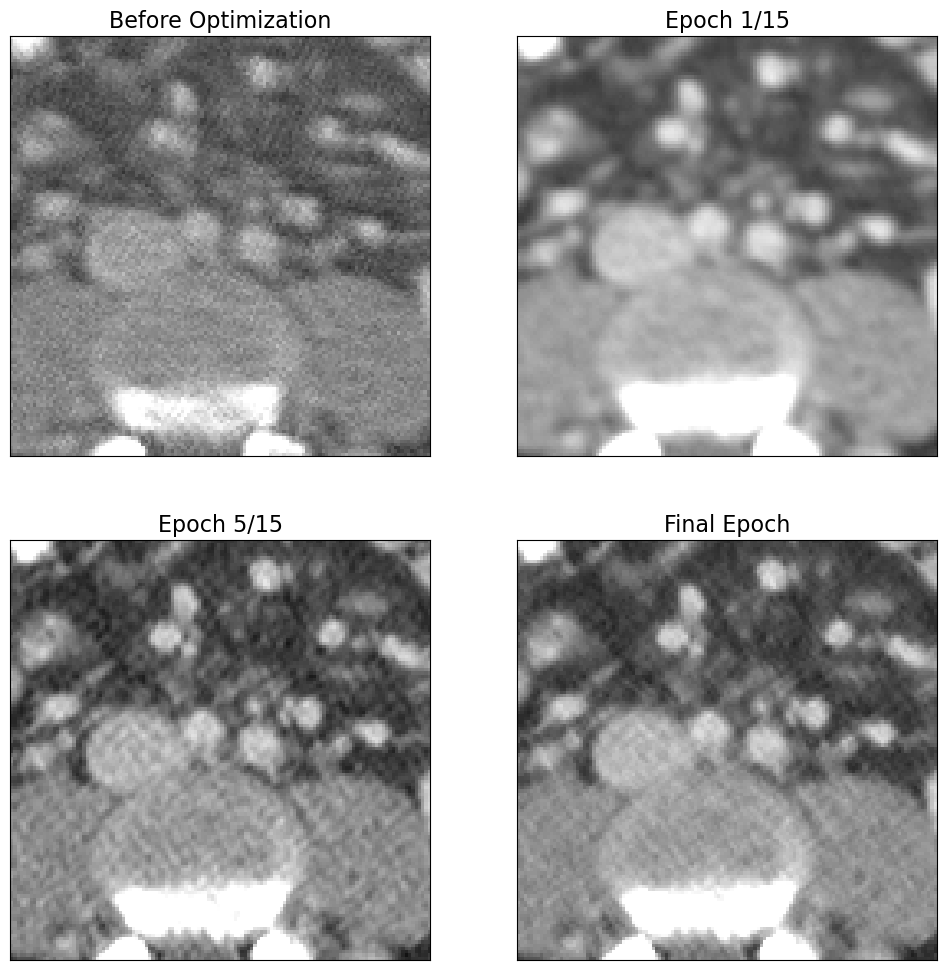

In [57]:
check_progress_ims(base_progress_ims)

## Now with augmentation

In [58]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

aug_denoising_model, aug_progress_ims, aug_progress_val = train(augment_training=True)

1/1 [==============================] - 0s 10ms/step
Training phase complete.


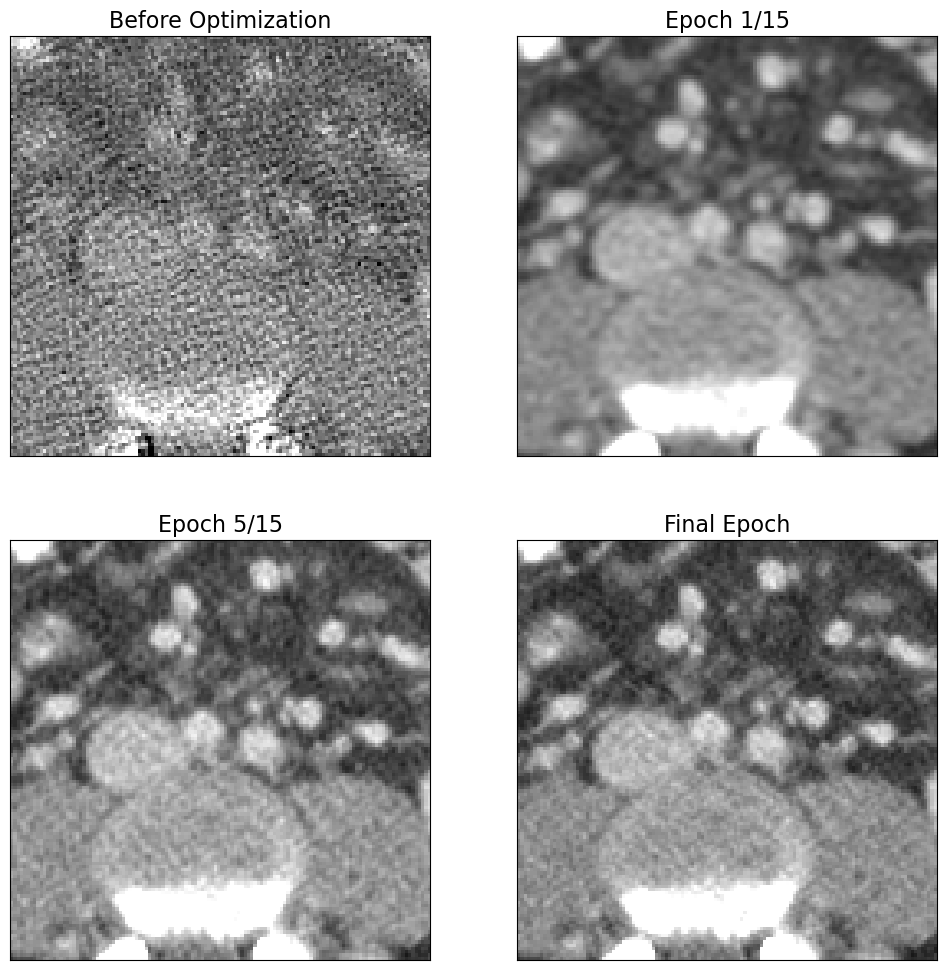

In [59]:
check_progress_ims(aug_progress_ims)

7/7 [==============================] - 0s 3ms/step


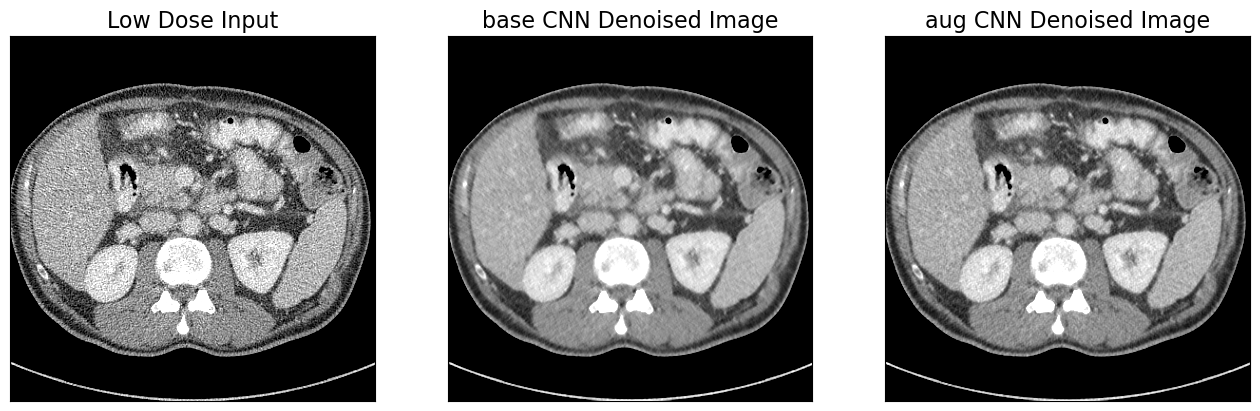

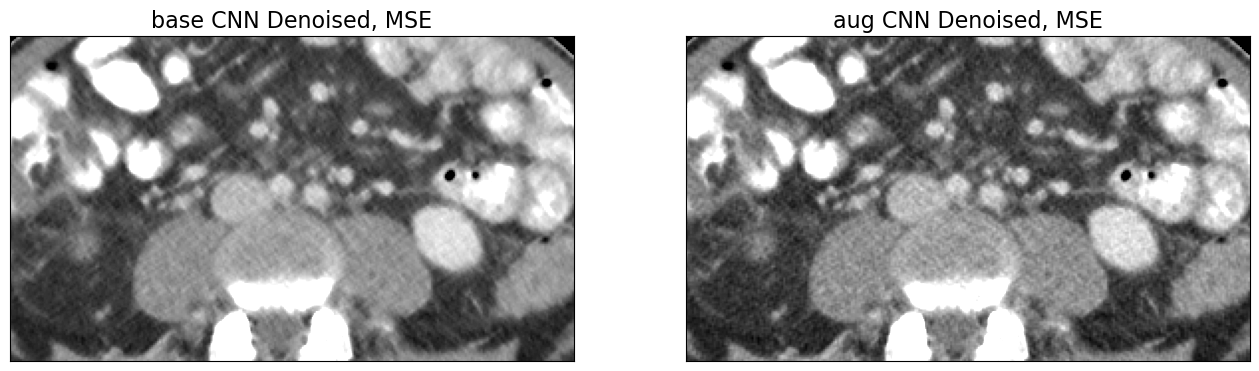

In [60]:
nexample = 2
base_CNNout = base_denoising_model.predict(test_input, batch_size=1)
aug_CNNout = aug_denoising_model.predict(test_input, batch_size=1)

plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[nexample, :, :, 0])


plt.subplot(1, 3, 2)
plt.title('base CNN Denoised Image', fontsize=16)
ctshow(base_CNNout[nexample, :, :, 0])

plt.subplot(1, 3, 3)
plt.title('aug CNN Denoised Image', fontsize=16)
ctshow(aug_CNNout[nexample, :, :, 0])

# Same as above, but with a different field of view
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('base CNN Denoised, MSE', fontsize=16)
ctshow(base_CNNout[3, 110:-110, 50:-50, 0])

plt.subplot(1, 2, 2)
plt.title('aug CNN Denoised, MSE', fontsize=16)
ctshow(aug_CNNout[3, 110:-110, 50:-50, 0])

Interesting, adding more augmentaton by lowering that threshold reduces overall denoising but improves retention of texture, see how this compares to simply adding back noise to the un-augmented cnn

So far it seems like if I add too much low frequency noise, it destroy  the training and leavee our high frequenices, so I nee to balance the weighting about how many of the traingin images have augmentation while having enough noise reduction

There's a balance between *how much* denoiosing and what frequencies to remove, so it seems like there's 2 parameters to balance

In [61]:
print("Evaluate")
result = base_denoising_model.evaluate(test_dataset)
dict(zip(base_denoising_model.metrics_names, result))

Evaluate
1/1 [==============================] - 0s 167ms/step - loss: 620.0717 - root_mean_squared_error: 24.9012


{'loss': 620.0717163085938, 'root_mean_squared_error': 24.9012393951416}

In [62]:
result = aug_denoising_model.evaluate(test_dataset)
dict(zip(aug_denoising_model.metrics_names, result))

1/1 [==============================] - 0s 213ms/step - loss: 525.9240 - root_mean_squared_error: 22.9330


{'loss': 525.9240112304688, 'root_mean_squared_error': 22.933032989501953}